In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.nn import Linear, Dropout, LayerNorm, BatchNorm1d
import torch.nn.functional as F
import torch.optim as optim
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import torch_geometric as T
from torch_geometric.nn import GCNConv, SAGEConv, GraphConv, global_mean_pool, global_add_pool
from torch.nn.utils import clip_grad_norm_

import networkx as nx

from sklearn.metrics import roc_curve, roc_auc_score
import random
from statistics import mean

In [2]:
# Read from csv
sig_df = pd.read_csv('Dijet_bb_pt20_50_dw.csv')
bkg_df = pd.read_csv('Dijet_qq_pt20_50_dw.csv')

In [3]:
sig_df.Jet0_nmuons

0         1
1         0
2         0
3         2
4         0
         ..
199995    0
199996    1
199997    1
199998    1
199999    1
Name: Jet0_nmuons, Length: 200000, dtype: int64

In [4]:
sig_df.Jet0_muon_ProbNNMu

0         0.652727
1        -1.000000
2        -1.000000
3         0.999296
4        -1.000000
            ...   
199995   -1.000000
199996    0.006640
199997    0.006640
199998    0.006640
199999    0.006640
Name: Jet0_muon_ProbNNMu, Length: 200000, dtype: float64

In [5]:
sig_df.Jet0_muon_IPchi2

0          140.421586
1           -1.000000
2           -1.000000
3         1332.784751
4           -1.000000
             ...     
199995      -1.000000
199996       4.598802
199997       4.598802
199998       4.598802
199999       4.598802
Name: Jet0_muon_IPchi2, Length: 200000, dtype: float64

In [6]:
# Distinguish signal and background
sig_df['IsB'] = 1
bkg_df['IsB'] = 0

# Separate Jet 0 and Jet 1 data
sig_jet0 = sig_df[sig_df.columns[sig_df.columns.str.contains("Jet0|IsB")]]
bkg_jet0 = bkg_df[bkg_df.columns[bkg_df.columns.str.contains("Jet0|IsB")]]

sig_jet1 = sig_df[sig_df.columns[sig_df.columns.str.contains("Jet1|IsB")]]
bkg_jet1 = bkg_df[bkg_df.columns[bkg_df.columns.str.contains("Jet1|IsB")]]

# Combine signal and background and shuffle
train_df = pd.concat([sig_jet0, bkg_jet0]).sample(frac=1, random_state=42).reset_index(drop=True)
test_df = pd.concat([sig_jet1, bkg_jet1]).sample(frac=1, random_state=42).reset_index(drop=True)

In [7]:
# Make cuts on data
def train_make_cuts(train_df, test_df):
    
    train_cut_df_sig = train_df[(train_df['IsB'] == 1) & (train_df['Jet0_MC_Match'] == 1) & (train_df['Jet0_MC_Jet_EfB'] > 0.6)]
    train_cut_df_bkg = train_df[(train_df['IsB'] == 0) & (train_df['Jet0_MC_Match'] == 1) & (train_df['Jet0_MC_Jet_EfB'] < 0.6) & (train_df['Jet0_MC_Jet_EfD'] < 0.6)]

    test_cut_df_sig = test_df[(test_df['IsB'] == 1) & (test_df['Jet1_MC_Match'] == 1) & (test_df['Jet1_MC_Jet_EfB'] > 0.6)]
    test_cut_df_bkg = test_df[(test_df['IsB'] == 0) & (test_df['Jet1_MC_Match'] == 1) & (test_df['Jet1_MC_Jet_EfB'] < 0.6) & (test_df['Jet1_MC_Jet_EfD'] < 0.6)]
    
    train_cut_df = pd.concat([train_cut_df_sig, train_cut_df_bkg], ignore_index=True)
    test_cut_df = pd.concat([test_cut_df_sig, test_cut_df_bkg], ignore_index=True)
    return train_cut_df, test_cut_df

# Calculate Delta R
def deltaR(df, eta_col, phi_col):
    df['DeltaR'] = None 

    for i, row in df.iterrows():
        eta = df.loc[i, eta_col]
        phi = df.loc[i, phi_col]
        deltaR = np.sqrt(eta ** 2 + phi ** 2)
        df.at[i, 'DeltaR'] = deltaR

# Duplicate data to lists matching the number of daughters/ nodes per jet/ row
def duplicate(df, cols, n_col):
    for col in cols:
        df[col] = df.apply(lambda row: [row[col]] * row[n_col] if isinstance(row[col], (float, int)) else row[col], axis=1)
    return df

# Convert string values into list of floats
def convert_to_lists(df, d_cols):
    for col in d_cols:
        df[col] = df[col].apply(lambda x: [float(num) for num in x.strip('[]').split(',')] if isinstance(x, str) else x)
    return df

Data preprocessing

In [8]:
# Make cuts to data
train_df, test_df = train_make_cuts(train_df, test_df)

In [9]:
# Calculate Delta R variable
deltaR(train_df, 'Jet0_Eta', 'Jet0_Phi')
deltaR(test_df, 'Jet1_Eta', 'Jet1_Phi')

In [10]:
# Track/ daughter kinematic features
train_d_cols = [col for col in train_df.columns if "_Daughters" in col]
test_d_cols = [col for col in test_df.columns if "_Daughters" in col]

# Jet input features
train_jet_cols = ['Jet0_Eta', 'Jet0_PT', 'Jet0_nmuons'] #, 'Jet0_nmuons', 'Jet0_muon_ProbNNMu', 'Jet0_muon_IPchi2'] later add DeltaR
test_jet_cols = ['Jet1_Eta', 'Jet1_PT', 'Jet1_nmuons'] #, 'Jet1_nmuons', 'Jet1_muon_ProbNNMu', 'Jet1_muon_IPchi2'] later add DeltaR

# Features columns (daughter kinematics + jet inputs)
train_f_cols = train_d_cols + train_jet_cols
test_f_cols = test_d_cols + test_jet_cols

# Duplicate single features for each node
train_df = duplicate(train_df, train_jet_cols, 'Jet0_nDaughters')
test_df = duplicate(test_df, test_jet_cols, 'Jet1_nDaughters')

# Convert strings into float lists
train_df = convert_to_lists(train_df, train_d_cols)
test_df = convert_to_lists(test_df, test_d_cols)

# Shuffle data
train_df = train_df.sample(frac=1).reset_index(drop=True)
test_df = test_df.sample(frac=1).reset_index(drop=True)

In [11]:
full_train_df = train_df
full_test_df = test_df

In [12]:
full_train_df

,Jet0_ENDVERTEX_X,Jet0_ENDVERTEX_Y,Jet0_ENDVERTEX_Z,Jet0_ENDVERTEX_XERR,Jet0_ENDVERTEX_YERR,Jet0_ENDVERTEX_ZERR,Jet0_ENDVERTEX_CHI2,Jet0_ENDVERTEX_NDOF,Jet0_OWNPV_X,Jet0_OWNPV_Y,...,Jet0_Hlt1Phys_TIS,Jet0_Hlt1Phys_TOS,Jet0_Hlt2Global_Dec,Jet0_Hlt2Global_TIS,Jet0_Hlt2Global_TOS,Jet0_Hlt2Phys_Dec,Jet0_Hlt2Phys_TIS,Jet0_Hlt2Phys_TOS,IsB,DeltaR
0,0.8377,-0.1541,-23.5924,0.0071,0.0072,0.0381,53.909210,157,0.838109,-0.155300,...,True,True,True,True,True,True,True,False,0,4.154309
1,0.8396,-0.1386,-33.8219,0.0224,0.0213,0.1122,12.653491,21,0.831125,-0.204096,...,True,True,True,True,True,True,True,True,1,3.416828
2,0.7865,-0.1848,-15.9677,0.0106,0.0107,0.0569,29.726864,61,0.792791,-0.113921,...,False,False,True,False,False,True,False,False,0,4.133397
3,0.9133,-0.1803,-1.6413,0.0076,0.0078,0.0401,47.444931,133,0.913348,-0.181918,...,True,True,True,True,True,True,True,False,0,2.285054
4,0.8382,-0.1255,-25.4882,0.0073,0.0072,0.0342,57.294060,143,0.837065,-0.125611,...,True,True,True,True,True,True,True,False,1,3.396954
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
305037,0.7787,-0.1337,15.3447,0.0086,0.0087,0.0410,45.148598,111,0.894099,-0.208316,...,True,True,True,True,True,True,True,False,0,3.23452
305038,0.8184,-0.1746,-3.9334,0.0128,0.0127,0.0700,12.172385,41,0.818402,-0.175371,...,True,True,True,True,True,True,True,True,0,2.910168
305039,0.8559,-0.2001,-14.6769,0.0081,0.0079,0.0400,47.589310,119,0.833013,-0.191782,...,False,True,True,True,True,True,True,True,1,3.997287
305040,0.8402,-0.1891,-20.8773,0.0059,0.0057,0.0323,116.449524,247,0.839866,-0.188761,...,True,False,True,True,True,True,True,False,1,3.330573


In [13]:
# Cut out some data for quicker runs
cut_train_df = pd.concat([train_df.head(1000), train_df.tail(1000)]) 
cut_test_df = pd.concat([test_df.head(1000), test_df.tail(1000)])

In [14]:
print(f"Train Delta R Min: {min(full_train_df.DeltaR)}")
print(f"Train Delta R Max: {max(full_train_df.DeltaR)}")

print(f"Test Delta R Min: {min(full_test_df.DeltaR)}")
print(f"Test Delta R Max: {max(full_test_df.DeltaR)}")

Train Delta R Min: 1.761115323640425
Train Delta R Max: 5.8529178004243185
Test Delta R Min: 1.7680778568110043
Test Delta R Max: 5.891085425652596


In [15]:
# Pick which size data to feed into model
train_df = cut_train_df
test_df = cut_test_df

In [16]:
training_data = train_df[train_f_cols]

In [17]:
train_df.IsB

0         0
1         1
2         0
3         0
4         1
         ..
305037    0
305038    0
305039    1
305040    1
305041    0
Name: IsB, Length: 2000, dtype: int64

In [18]:
train_df.IsB

0         0
1         1
2         0
3         0
4         1
         ..
305037    0
305038    0
305039    1
305040    1
305041    0
Name: IsB, Length: 2000, dtype: int64

In [19]:
# Create node feature array: [jet][daughter][feature]
def node_features(df, features_cols):
    features_list = []
    
    for _, row in df.iterrows():

        max_nodes = max(len(row[col]) if isinstance(row[col], list) else 1 for col in features_cols)
        jet_nodes = [[] for _ in range(max_nodes)]
        
        for column in features_cols:
            cell_value = row[column]

            if isinstance(cell_value, list):
                for i in range(max_nodes):
                    jet_nodes[i].append(cell_value[i])
            else:
                for node_features in jet_nodes:
                    node_features.append(cell_value)
        
        features_list.append(jet_nodes)
    
    return np.array(features_list, dtype=object)

# Create graphs for each jet - orig
def create_data_objects(df, features_array):
    data_objects = []
    for idx, features in enumerate(features_array):

        x = torch.tensor(features, dtype=torch.float)

        num_nodes = x.size(0)
        num_classes = 2 # binary classification

        # Fully connected edges
        G = nx.complete_graph(num_nodes)
        edge_index = torch.tensor(list(G.edges)).t().contiguous()

        y = torch.tensor([df['IsB'].iloc[idx]], dtype=torch.float)
        
        data = Data(x=x, edge_index=edge_index, y=y, num_classes=num_classes, num_nodes=num_nodes)
        data_objects.append(data)

    return data_objects

# Extract node features
train_features = node_features(train_df, train_f_cols)
test_features = node_features(test_df, test_f_cols)

# Create graphs for each jet
train_data = create_data_objects(train_df, train_features)
test_data = create_data_objects(test_df, test_features)

# Load Data in batches
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

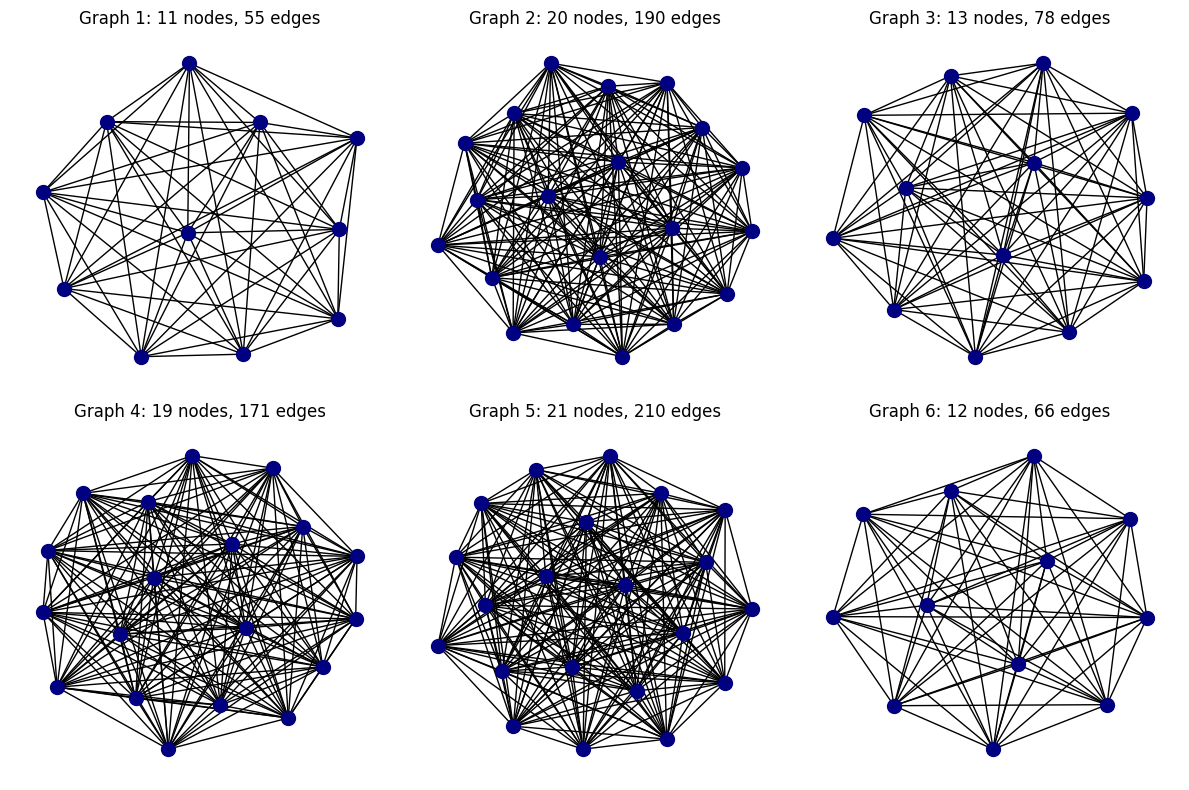

In [20]:
# Visualize some graphs
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.flatten()

for i, data in enumerate(train_loader.dataset[:6]):
    G = nx.Graph()
    G.add_edges_from(data.edge_index.t().tolist())

    nx.draw(G, ax=axes[i], node_color='navy', node_size=100)
    
    axes[i].set_title(f"Graph {i+1}: {data.num_nodes} nodes, {data.edge_index.size(1)} edges")

plt.tight_layout()
plt.show()

In [21]:
for data in train_loader:
    print(f"x shape: {data.x[0]}") # [num_nodes, num_features]
    print(f"edge_index shape: {data.edge_index.shape}") # [2, num_edges] fully connected
    print(f"y: {data.y}") # labels
    print(f"batch shape: {data.batch.shape[0]}") #num nodes in this batch
    print("###########################################")

x shape: tensor([ 3.9095e+04,  1.3174e+03, -2.1100e+02,  1.1920e+03, -5.6088e+02,
         3.9072e+04,  4.0832e+00, -4.3980e-01, -1.0000e+00,  8.2658e-02,
         1.1103e-01,  9.1775e-03,  1.4356e-02,  1.1473e-03,  6.6239e-04,
         8.9089e-01, -1.0000e+03,  1.5192e+00,  2.3600e+02,  7.1500e-02,
         2.2850e-01, -3.7286e+01,  1.1920e+03, -5.6088e+02,  3.9072e+04,
        -1.0000e+03, -1.0000e+03, -1.0000e+03, -1.0000e+03,  3.6773e+00,
         1.6372e+04,  0.0000e+00])
edge_index shape: torch.Size([2, 7818])
y: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1.,
        1., 0., 0., 1., 0., 1., 0., 0., 1., 0., 1., 0., 1., 1., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 1., 0., 0., 1., 0., 0., 0.,
        1., 0., 1., 0., 0., 0., 0., 0., 0., 1.])
batch shape: 967
###########################################
x shape: tensor([ 9.3570e+03,  8.3074e+02, -2.1100e+02,  7.7473e+02,  2.9989e+02,
         9.3190e+03,  3.1126e+00,  3.6933e-

In [23]:
# Define GNN model
class GNN(torch.nn.Module):
    def __init__(self):
        super(GNN, self).__init__()
        hidden_channels = 64
        self.conv1 = GraphConv(len(train_f_cols), hidden_channels)
        self.bn1 = BatchNorm1d(hidden_channels)
        self.conv2 = GraphConv(hidden_channels, hidden_channels)
        self.bn2 = BatchNorm1d(hidden_channels)
        self.conv3 = GraphConv(hidden_channels, hidden_channels)
        self.bn3 = BatchNorm1d(hidden_channels)
        self.conv4 = GraphConv(hidden_channels, hidden_channels)
        self.bn4 = BatchNorm1d(hidden_channels)
        self.conv5 = GraphConv(hidden_channels, hidden_channels)
        self.bn5 = BatchNorm1d(hidden_channels)
        self.lin = Linear(hidden_channels, 1)
        self.dropout = torch.nn.Dropout(0.5)

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.conv3(x, edge_index)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.conv4(x, edge_index)
        x = self.bn4(x)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.conv5(x, edge_index)
        x = self.bn5(x)
        x = F.relu(x)
        x = self.dropout(x)

        x = global_mean_pool(x, batch)
        x = self.lin(x)
        return x.squeeze(1)

model = GNN()

# Define optimizer and criterion
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-6)
criterion = nn.BCEWithLogitsLoss()

# Training loop
def train():
    model.train()
    total_loss = 0

    for data in train_loader:
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.batch)
        loss = criterion(out, data.y.float())
        clip_grad_norm_(model.parameters(), max_norm=1.0)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs
        
    return total_loss / len(train_loader.dataset)

# Testing function
def test(loader):
    model.eval()
    total_correct = 0
    total_samples = 0
    
    with torch.no_grad():
        for data in loader:
            out = model(data.x, data.edge_index, data.batch)
            pred = (out > 0).float()
            correct = (pred.squeeze() == data.y.float()).sum().item()
            total_correct += correct
            total_samples += len(data.y)
    
    return total_correct / total_samples

# Check gradients
def check_gradients():
    model.train()
    data = next(iter(train_loader))
    optimizer.zero_grad()
    out = model(data.x, data.edge_index, data.batch)
    loss = criterion(out.squeeze(-1), data.y.float())
    loss.backward()

    print(' ')
    print('Grad norms:')
    for name, param in model.named_parameters():
        if param.requires_grad:
            if param.grad is not None:
                grad_norm = param.grad.norm().item()
                print(f"    {name}: {grad_norm:.6f}")

# Training parameters
num_epochs = 25

# Lists to store loss and accuracy values
loss_values = []
train_acc_values = []
test_acc_values = []

# Training loop
for epoch in range(num_epochs):
    loss = train()
    loss_values.append(loss)
    train_acc = test(train_loader)
    train_acc_values.append(train_acc)
    test_acc = test(test_loader)
    test_acc_values.append(test_acc)

    print(f'Epoch: {epoch+1:03d}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

# Check gradients after training
check_gradients()

Epoch: 001, Loss: 0.6757, Train Acc: 0.6070, Test Acc: 0.6795
Epoch: 002, Loss: 0.6711, Train Acc: 0.6110, Test Acc: 0.6810
Epoch: 003, Loss: 0.6682, Train Acc: 0.6105, Test Acc: 0.6815
Epoch: 004, Loss: 0.6662, Train Acc: 0.6120, Test Acc: 0.6785
Epoch: 005, Loss: 0.6609, Train Acc: 0.6110, Test Acc: 0.6805
Epoch: 006, Loss: 0.6625, Train Acc: 0.6120, Test Acc: 0.6805
Epoch: 007, Loss: 0.6605, Train Acc: 0.6135, Test Acc: 0.6805
Epoch: 008, Loss: 0.6616, Train Acc: 0.6120, Test Acc: 0.6810
Epoch: 009, Loss: 0.6616, Train Acc: 0.6120, Test Acc: 0.6800
Epoch: 010, Loss: 0.6631, Train Acc: 0.6125, Test Acc: 0.6805
Epoch: 011, Loss: 0.6597, Train Acc: 0.6145, Test Acc: 0.6790
Epoch: 012, Loss: 0.6640, Train Acc: 0.6135, Test Acc: 0.6805
Epoch: 013, Loss: 0.6595, Train Acc: 0.6110, Test Acc: 0.6800
Epoch: 014, Loss: 0.6615, Train Acc: 0.6135, Test Acc: 0.6780
Epoch: 015, Loss: 0.6587, Train Acc: 0.6135, Test Acc: 0.6795
Epoch: 016, Loss: 0.6593, Train Acc: 0.6140, Test Acc: 0.6780
Epoch: 0

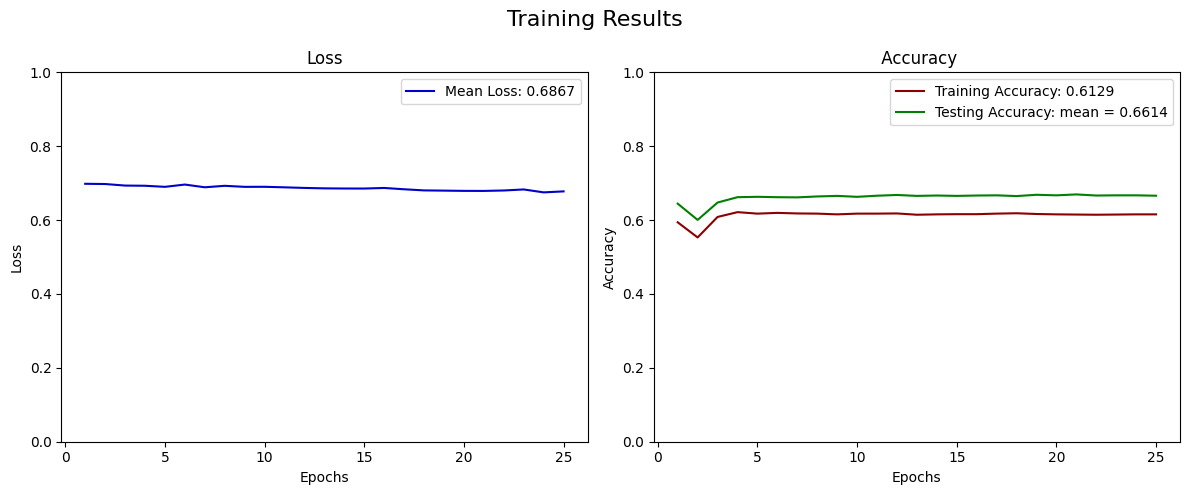

In [60]:
# Plot Loss and Accuracy
def plot_training_results(loss_values, train_acc_values, test_acc_values):
    epochs = range(1, len(loss_values) + 1)  # Create a list of epoch numbers
    mean_train_acc = mean(train_acc_values)
    mean_test_acc = mean(test_acc_values)
    mean_loss = mean(loss_values)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    fig.suptitle('Training Results', fontsize=16)

    # Plot Loss
    ax1.plot(epochs, loss_values, color='mediumblue', label=(f"Mean Loss: {mean_loss:.4f}"))
    ax1.set_ylim(0, 1)
    ax1.set_title('Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend(loc='best')

    # Plot  Accuracy
    ax2.plot(epochs, train_acc_values, color='darkred', label=(f"Training Accuracy: {mean_train_acc:.4f}"))
    ax2.plot(epochs, test_acc_values, color='green', label=(f"Testing Accuracy: mean = {mean_test_acc:.4}"))
    ax2.set_ylim(0, 1)
    ax2.set_title(' Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend(loc='best')

    plt.tight_layout()
    plt.show()

# After your training loop, call the function:
plot_training_results(loss_values, train_acc_values, test_acc_values)

Compute ROC Curve and AUC

In [61]:
# Get model predictions
y_true = []  # class values (0 or 1)
y_scores = []  # predicted probabilities or scores

model.eval()
with torch.no_grad():
    for data in test_loader:
        out = model(data.x, data.edge_index, data.batch)
        prob = torch.sigmoid(out)
        
        y_true.append(data.y.numpy().flatten())
        y_scores.append(prob.numpy().flatten())

y_true = np.concatenate(y_true)
y_scores = np.concatenate(y_scores)

In [62]:
# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
auc = roc_auc_score(y_true, y_scores)

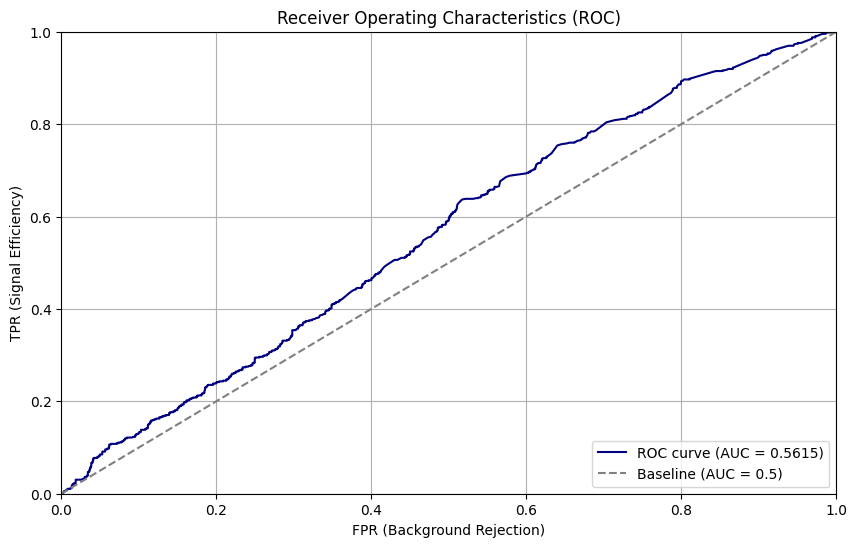

In [63]:
# Plot ROC Curve and show AUC
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='navy', label=f'ROC curve (AUC = {auc:.4f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--', label='Baseline (AUC = 0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.ylabel('TPR (Signal Efficiency)')
plt.xlabel('FPR (Background Rejection)')
plt.title('Receiver Operating Characteristics (ROC)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

Test - create gaussian distribution around 10 for background and 25 for signal (std = 5) to see if it picks up on it

In [27]:
# Create Gauss values for each daughter based on IsB column

def generate_gaussian(mean, std_dev):
    return random.gauss(mean, std_dev)

def generate_gaussian_list(row, mean1, mean2, std_dev):
    num_daughters = int(row['Jet0_nDaughters'] if 'Jet0_nDaughters' in row else row['Jet1_nDaughters'])
    mean = mean1 if row['IsB'] == 1 else mean2
    return [generate_gaussian(mean, std_dev) for _ in range(num_daughters)]

# Apply the function to create the new 'Gauss' column
train_df['Gauss'] = train_df.apply(lambda row: generate_gaussian_list(row, 10, 25, 5), axis=1)
test_df['Gauss'] = test_df.apply(lambda row: generate_gaussian_list(row, 10, 25, 5), axis=1)

# Print some results to verify
print("Training set:")
print(train_df[['IsB', 'Jet0_nDaughters', 'Gauss']].head())
print("\nTest set:")
print(test_df[['IsB', 'Jet1_nDaughters', 'Gauss']].head())

Training set:
   IsB  Jet0_nDaughters                                              Gauss
0    1               10  [10.51418292184592, 15.02028378064799, 5.72948...
1    1               13  [13.51948270476789, 15.86681130885692, 11.5053...
2    1               14  [9.4791449346758, 10.483479097360773, 14.15940...
3    1               18  [7.426791390640632, 6.6244570877414235, 8.1917...
4    1               20  [7.96436238864123, 16.604054436071568, 9.29034...

Test set:
   IsB  Jet1_nDaughters                                              Gauss
0    1               13  [11.256530592177814, 16.08326398693623, 6.5832...
1    0                8  [28.282289127924187, 22.109120541392873, 20.57...
2    1                8  [12.236832522945562, 0.5601091084074046, 2.185...
3    1                9  [14.00375375259966, 9.480684505406122, 3.64701...
4    1               13  [0.32266692309750233, 6.780339591825353, 7.358...
